In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

In [9]:
file_path = 'creditcard_2013.csv'
data = pd.read_csv(file_path)

X = data.drop('Class', axis=1)

In [10]:

tot_seconds = X['Time']
X['sin_tot_seconds'] = np.sin(2 * np.pi * tot_seconds / (24 * 60 * 60))
X['cos_tot_seconds'] = np.cos(2 * np.pi * tot_seconds / (24 * 60 * 60))
X = X.drop('Time', axis=1)

In [11]:

amount_pt = PowerTransformer(method='box-cox')
X['Amount'] = amount_pt.fit_transform(X[['Amount']] + 1e-9)

y = data['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
class NeuralNetTwoHiddenLayers(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetTwoHiddenLayers, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze()


model = NeuralNetTwoHiddenLayers(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [13]:
num_epochs = 5
train_start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    epoch_start_time = time.time()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Duration: {epoch_duration:.2f} seconds')

train_end_time = time.time()
training_duration = train_end_time - train_start_time
print(f'Total Training Time: {training_duration:.2f} seconds')

Epoch 1/5, Loss: 0.0001, Duration: 9.10 seconds
Epoch 2/5, Loss: 0.0001, Duration: 9.10 seconds
Epoch 3/5, Loss: 0.0001, Duration: 9.12 seconds
Epoch 4/5, Loss: 0.0000, Duration: 9.77 seconds
Epoch 5/5, Loss: 0.0000, Duration: 9.66 seconds
Total Training Time: 46.76 seconds


In [14]:
model_save_path = 'neuralnet_two_hidden_layers_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to neuralnet_two_hidden_layers_model.pth


Total Training Time: 46.78 seconds
Model saved to neuralnet_two_hidden_layers_model.pth
Total Evaluation Time: 1.11 seconds
Test Accuracy: 0.9994
Precision: 0.8280
Recall (TPR): 0.7857
TNR: 0.9997
F1 Score: 0.8063
ROC AUC: 0.9762


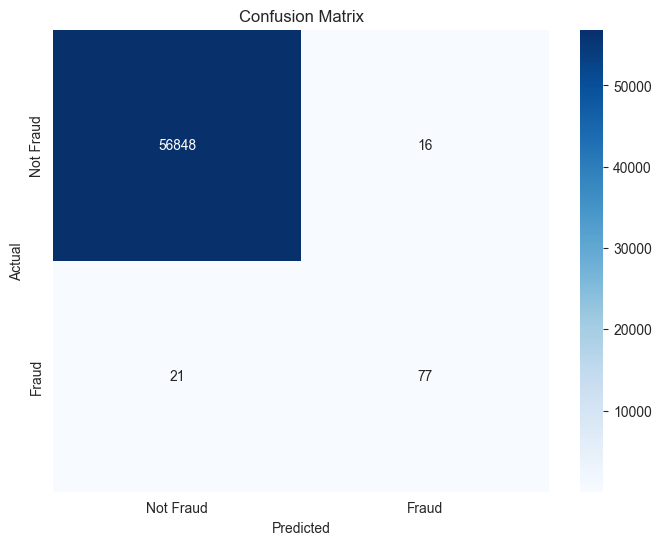

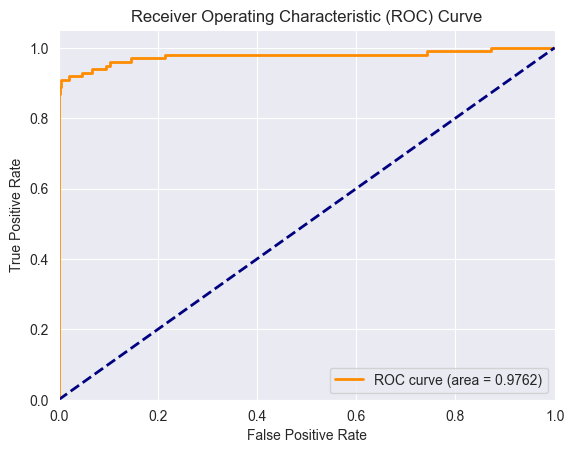

Neural Network with 2 hidden layers (128, 128)


In [15]:
train_end_time = time.time()
training_duration = train_end_time - train_start_time
print(f'Total Training Time: {training_duration:.2f} seconds')

model_save_path = 'neuralnet_two_hidden_layers_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

eval_start_time = time.time()
model.eval()
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probs = outputs
        predicted = (outputs > 0.5).float()
        all_preds.extend(predicted.tolist())
        all_labels.extend(y_batch.tolist())
        all_probs.extend(probs.tolist())

eval_end_time = time.time()
evaluation_duration = eval_end_time - eval_start_time
print(f'Total Evaluation Time: {evaluation_duration:.2f} seconds')

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_probs)

tpr = recall

cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
tnr = tn / (tn + fp)

# Print metrics
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall (TPR): {tpr:.4f}')
print(f'TNR: {tnr:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("Neural Network with 2 hidden layers (128, 128)")